In [1]:
# load libs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

In [2]:
# definition of a simple fc model [2, 32, 64, 1]
class MOGANet(nn.Module):
    def __init__(self):
        super(MOGANet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

class MOGADataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

In [3]:
# define train and test functions
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        # compute output
        outputs = model(x)
        loss = criterion(outputs, y)
        train_loss += loss.item()
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    return train_loss

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            
            # compute output
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item()
            
    test_loss /= len(test_loader)
    return test_loss

In [4]:
# Use CUDA
device = torch.device("cpu")

random.seed(2020) 
torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)

# load files
moga = pickle.load(open("ma.0211.pkl", "rb"))
x_train, x_test = moga["x_train"], moga["x_test"]
y_train, y_test = moga["y_train"], moga["y_test"]
x_mean, x_std = moga["x_mean"], moga["x_std"]

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()

In [5]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 4}

# dataloader
train_data = MOGADataset(x_train, y_train)
train_loader = DataLoader(dataset=train_data, **params)

test_data = MOGADataset(x_test, y_test)
test_loader = DataLoader(dataset=test_data, **params)

In [6]:
model = MOGANet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

In [7]:
# Training here
for t in range(500):
    train_loss = train(model, device, train_loader, optimizer, criterion) 
    test_loss = test(model, device, test_loader, criterion)
    if t%10 == 0:
        print(t, train_loss, test_loss)
    
    scheduler.step(test_loss)

0 5.429379192176303e-05 4.718390897623907e-06
10 7.017116752496708e-07 4.930460457163623e-07
20 4.3175683631324555e-07 3.942831178594012e-07
30 3.8288177447776197e-07 4.1822090475957186e-07
40 3.619298967973101e-07 3.371244749823373e-07
50 3.5479088871723114e-07 3.989171792327374e-07
60 3.6991652050801933e-07 3.4522303359151414e-07
70 3.3366061514939426e-07 3.573373773384758e-07
80 3.299903332147592e-07 3.1931083593198964e-07
90 3.274291355815965e-07 3.191412317070371e-07
100 3.2658674485401e-07 3.3441696384519456e-07
110 3.158563434034211e-07 3.0969951864518195e-07
120 3.1542455270184096e-07 3.1245047022084016e-07
130 3.1003575113364855e-07 3.071993559811847e-07
140 3.102622168873125e-07 3.2174444145823745e-07
150 3.0641526669790257e-07 3.0886521855495804e-07
160 3.063750668629723e-07 3.0201872430987586e-07
170 3.0597075859969777e-07 3.014010120744357e-07
180 3.0584502523952737e-07 3.0739350620478945e-07
190 3.040736159323809e-07 3.000644594178777e-07
200 3.031384400340486e-07 2.99446

In [8]:
# save trained model
torch.save(model.state_dict(), 'ma-0211.pth')
#model.load_state_dict(torch.load("ma-0211.pth"))

In [9]:
model.eval()
Yp = model(x_test)
print("test MSE from criterion")
MSE = criterion(Yp, y_test).item()
print(MSE)

Yp = Yp[:,0].detach().numpy()
y_test = y_test[:,0].detach().numpy()

delta_y = Yp - y_test
RMSE = np.sqrt(MSE)
print("test RMSE of original data")
print(RMSE)

test MSE from criterion
2.989582128520851e-07
test RMSE of original data
0.0005467707132355254


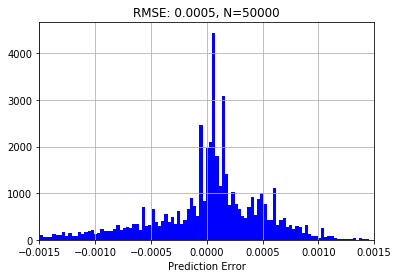

In [15]:
# plot RMSE
plt.figure(figsize=(6,4))
num_bins = 200
plt.hist(delta_y, num_bins, facecolor='blue')
plt.xlabel('Prediction Error')
plt.xlim(-0.0015,0.0015)
plt.grid(True)
plt.title('RMSE: %.4f, N=%d' % (RMSE,len(x_test)))
plt.show()

In [16]:
# check mean ans std
print(np.std(y_test))
print(np.mean(y_test))
print(max(y_test), min(y_test))

0.0012999743
-0.027380632
-0.0125 -0.02883333


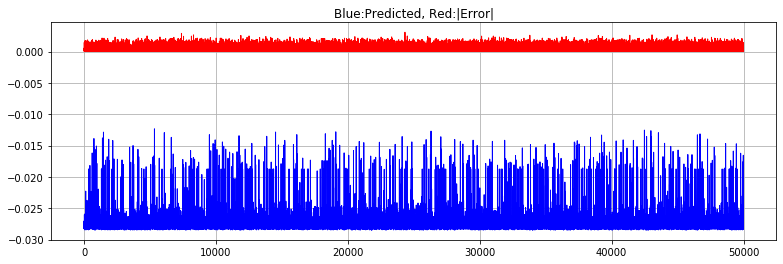

In [17]:
# Viz Yp and |Error|
l = np.array([x for x in range(len(y_test))])
plt.figure(figsize=(13,4))
plt.title("Blue:Predicted, Red:|Error|")
plt.plot(l, Yp, 'b-', linewidth=1)
plt.plot(l, abs(delta_y), 'r-', linewidth=1)
plt.grid(True)
plt.show()

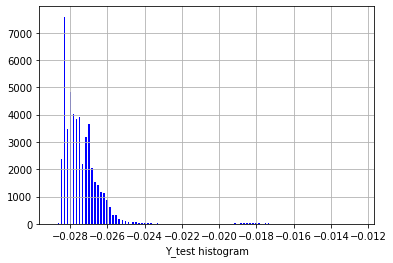

In [18]:
# Viz y_test hist
plt.figure(figsize=(6,4))
num_bins = 200
plt.hist(y_test, num_bins, facecolor='blue')
plt.xlabel('Y_test histogram')
plt.grid(True)
plt.show()